In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.integrate import simpson
from scipy.optimize import minimize


plt.rc('font', family='serif')
plt.rc('text.latex', preamble=r'\usepackage{amsmath,bm}')
matplotlib.rcParams.update({'font.size': 16})

# colorblind colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
markers = ['s','o','^','x']

# matplotlib.use('TkAgg')

In [2]:
# infile = "../min_energy_loss/data_phase_one_tmax_0.0001_SAA_sweep/data_opt_nfp4_phase_one_aspect_7.0_iota_1.05_mean_energy_SAA_surface_0.25_tmax_0.0001_bobyqa_mmode_1_iota_None.pickle"
# infile = "../min_energy_loss/data_phase_one_tmax_0.0001_SAA_sweep/data_opt_nfp4_phase_one_aspect_7.0_iota_0.89_mean_energy_SAA_surface_0.25_tmax_0.0001_bobyqa_mmode_2_iota_None.pickle"
# infile = "../min_energy_loss/data_phase_one_tmax_0.0001_SAA_sweep/data_opt_nfp4_phase_one_aspect_7.0_iota_1.05_mean_energy_SAA_surface_0.25_tmax_0.0001_bobyqa_mmode_2_iota_None.pickle"
# infile = "../min_energy_loss/data_phase_one_tmax_0.0001_SAA_sweep/data_opt_nfp4_phase_one_aspect_7.0_iota_1.44_mean_energy_SAA_surface_0.25_tmax_0.0001_bobyqa_mmode_2_iota_None.pickle"

# infile = '../min_energy_loss/data_phase_one_tmax_0.01_SAA_sweep/data_opt_nfp4_phase_one_aspect_7.0_iota_-1.043_mean_energy_SAA_surface_0.25_tmax_0.01_bobyqa_mmode_2_iota_None.pickle'
# infile = '../min_energy_loss/data_phase_one_tmax_0.01_SAA_sweep/data_opt_nfp4_phase_one_aspect_7.0_iota_-1.043_mean_energy_SAA_surface_0.25_tmax_0.01_bobyqa_mmode_3_iota_None.pickle'
infile = '../min_energy_loss/data_phase_one_tmax_0.01_SAA_sweep/data_opt_nfp4_phase_one_aspect_7.0_iota_0.89_mean_energy_SAA_surface_0.25_tmax_0.01_bobyqa_mmode_2_iota_None.pickle'
# infile = '../min_energy_loss/data_phase_one_tmax_0.01_SAA_sweep/data_opt_nfp4_phase_one_aspect_7.0_iota_0.89_mean_energy_SAA_surface_0.25_tmax_0.01_bobyqa_mmode_3_iota_None.pickle'
# infile = '../min_energy_loss/data_phase_one_tmax_0.01_SAA_sweep/data_opt_nfp4_phase_one_aspect_7.0_iota_1.44_mean_energy_SAA_surface_0.25_tmax_0.01_bobyqa_mmode_2_iota_None.pickle'
# infile = '../min_energy_loss/data_phase_one_tmax_0.01_SAA_sweep/data_opt_nfp4_phase_one_aspect_7.0_iota_1.44_mean_energy_SAA_surface_0.25_tmax_0.01_bobyqa_mmode_3_iota_None.pickle'

In [3]:
indata = pickle.load(open(infile,"rb"))
aspect_target = indata['aspect_target']
grad_qs = indata['post_process_s_0.25']['grad_qs']
grad_aspect = indata['post_process_s_0.25']['grad_aspect']
grad_mirror = indata['post_process_s_0.25']['grad_mirror']
qs0 = indata['post_process_s_0.25']['qs0']
mirror0 = indata['post_process_s_0.25']['mirror0']
aspect0 = indata['post_process_s_0.25']['aspect0']
grad_energy = indata['post_process_s_0.25']['grad_energy']
energy0 = indata['post_process_s_0.25']['energy0']
T_ls = indata['post_process_s_0.25']['T_ls']
X_ls = indata['post_process_s_0.25']['X_ls']
qs_ls = indata['post_process_s_0.25']['qs_ls'] 
energy_ls = indata['post_process_s_0.25']['energy_ls']
aspect_ls = indata['post_process_s_0.25']['aspect_ls']
mirror_ls = indata['post_process_s_0.25']['mirror_ls']
c_times_ls = indata['post_process_s_0.25']['c_times_ls']
tmax = indata['post_process_s_0.25']['tmax']
n_particles = indata['post_process_s_0.25']['n_particles']
dim_x = len(grad_energy)
helicity_m = indata['post_process_s_0.25']['helicity_m']
helicity_n = indata['post_process_s_0.25']['helicity_n']
mirror_stz_grid = indata['post_process_s_0.25']['mirror_stz_grid']
mirror_ns = indata['post_process_s_0.25']['mirror_ns']
mirror_ntheta = indata['post_process_s_0.25']['mirror_ntheta']
mirror_nzeta = indata['post_process_s_0.25']['mirror_nzeta']
c_times_plus = indata['post_process_s_0.25']['c_times_plus']
c_times0 = indata['post_process_s_0.25']['c_times0']

In [4]:
Energy = lambda t,tmax:  3.5*np.exp(-2*t/tmax)
Time = lambda t,tmax: tmax - t

# Check the KKT conditions

We first determine the "essentially-active" constraints, indexed I.
We ignore primal feasibility by re-defining the constraints the constraint right hand side ```eps[I]``` to be ```eps[I] = c(xopt)[I]```.
By complementary slackness, the dual variables `lam` are zero for the inactive constraints `lam[j] = 0` for `j` not in `I`.
To find the remaining multipliers we solve the QP, 
```min_{lam[I] >= 0} ||grad_energy + sum_{i in I} lam_i * grad_constraint_i ||^2 ```

In [5]:
# determine the "essentially-active" constraints
ctol = 1e-3
active_aspect = aspect0 >= aspect_target - ctol
active_mirror = mirror0 >= 0.0 - ctol
print('active aspect constraint: ',active_aspect)
print('num active mirror constraints: ',np.sum(active_mirror))

active aspect constraint:  False
num active mirror constraints:  6


In [8]:
# solve for the lagrange multipliers

if active_aspect:
    n_con = np.sum(active_mirror)+1
    A = np.zeros((n_con,dim_x))
    A[0] = grad_aspect
    A[1:] = np.copy(grad_mirror[active_mirror])
else:
    n_con = np.sum(active_mirror)
    A = np.copy(grad_mirror[active_mirror].T)
    
def obj(lam):
    """
    sum (Ax - b)**2 = (Ax - b) @ (Ax-b) = b @ b -2*b@ Ax  + x A.T A x
    """
    return np.sum((A @ lam - grad_energy)**2)
def grad(lam):
    """
    grad = -2A.T @ b + 2 A.TAx = 2A.T(Ax - b)
    """
    return 2*A.T @ (A @ lam - grad_energy)

options = {'gtol':1e-12}
bounds = np.zeros((n_con,2))
bounds[:,1] = np.inf
lam = np.zeros(n_con)
res = minimize(obj,lam,jac = grad,bounds=bounds,method='L-BFGS-B',options=options)
lam = res.x

print('optimal objective',obj(lam))
print('norm(grad)^2',grad_energy @ grad_energy)
if active_aspect:
    print('aspect lagrange multipliers',lam[0])
    print('mirror lagrange multipliers',lam[1:])
else:
    print('mirror lagrange multipliers',lam)
print('stationary cond', grad_energy  - A @ lam)

print("")
print(res)

optimal objective 355.92213454113175
norm(grad)^2 355.92213454113175
mirror lagrange multipliers [0. 0. 0. 0. 0. 0.]
stationary cond [ 9.48645119e-03 -1.10360948e-01  2.74631788e+00  1.19180448e+00
 -1.19528713e-01  4.47701925e+00  1.40432106e+01 -1.76705481e-01
  6.07413671e-01  2.59206639e-01  1.48884046e-01  1.06243218e+01
 -6.73830945e-02 -1.40976729e-01  2.57476900e+00  3.15179375e-03
 -1.37420349e-01  7.83906179e-01  1.05862250e+00  1.92913878e-01
 -2.86407100e-01  3.49202702e-02  1.52837973e+00  2.33395882e+00]

      fun: 355.92213454113175
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([104.77807563,  14.66055299,  15.64877109,  14.66055299,
        15.64877109, 104.77807563])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0., 0., 0., 0., 0.])


# Look at the QS linesearch 

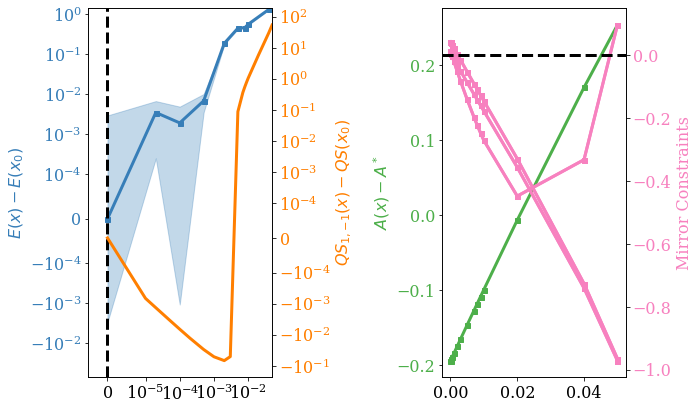

In [17]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,6), ncols=2)

# down select indexes to avoid computational noise in plot
idx_down = range(0,len(T_ls),2)

# energy
ax1.plot(T_ls[idx_down],energy_ls[idx_down]-energy0,marker='s',markersize=5,linewidth=3,color=colors[0],label='energy')
ax1.set_ylabel("$E(x) - E(x_0)$",color=colors[0])
ax1.tick_params(axis="y", labelcolor=colors[0])
# error bars
energy_ls_std = np.std(Energy(c_times_ls,tmax),axis=1)
energy_ls_std_err = 1.96*energy_ls_std/np.sqrt(n_particles)
ax1.fill_between(T_ls[idx_down],energy_ls[idx_down]-energy0 + energy_ls_std_err[idx_down],energy_ls[idx_down]-energy0 - energy_ls_std_err[idx_down],color=colors[0],alpha=0.3)

# quasisymmetry
ax3 = ax1.twinx()
ax3.plot(T_ls,qs_ls-qs0,linewidth=3,color=colors[1],label='QS')
ax3.set_ylabel("$QS_{{%s},{%s}}(x) - QS(x_0)$"%(helicity_m,helicity_n),color=colors[1])
ax3.tick_params(axis="y", labelcolor=colors[1])
# # plot a feasibility line
if np.sum(active_mirror)> 0:
    idx_feas = np.any(mirror_ls[:,active_mirror]>= 0.0,axis=1)
    x_feas = np.min(T_ls[idx_feas])
    ax1.axvline(x=x_feas,color='k',linestyle='--',linewidth=3,label='feasibility boundary')


# constraints
ax2.plot(T_ls,aspect_ls-aspect_target,marker='s',color=colors[2],markersize=5,linewidth=3,label='aspect')
ax2.set_ylabel("$A(x) - A^*$",color=colors[2])
ax2.tick_params(axis="y", labelcolor=colors[2])
ax4 = ax2.twinx()
if np.sum(active_mirror)>0:
    ax4.plot(T_ls,mirror_ls[:,active_mirror],color=colors[3],marker='s',markersize=5,linewidth=3,label='mirror')
    ax4.set_ylabel("Mirror Constraints",color=colors[3])
    ax4.tick_params(axis="y", labelcolor=colors[3])
    ax4.axhline(y=0,color='k',linestyle='--',linewidth=3,label='feasibility boundary')

ax1.set_yscale('symlog',linthresh=1e-4)
ax3.set_yscale('symlog',linthresh=1e-4)
ax1.set_xscale('symlog',linthresh=1e-5)
ax1.set_xlim((-5e-6,np.max(T_ls)))
# ax2.set_xscale('log')
# ax2.set_yscale('symlog',linthresh=1e-5)
plt.tight_layout()

# Look at constraint activities

Look at the s and theta locations of the activities.
Linesearh the active constraint directions.

Text(0.5, 1.0, 'Active $B$-field constraint in $(s,\\theta)$')

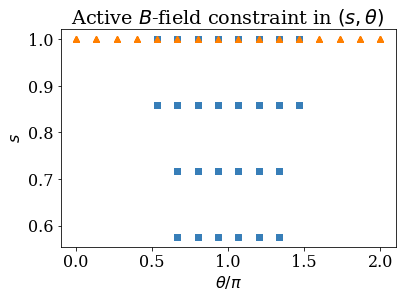

In [68]:

# find the s-values of the active constraints
n_ub_con = mirror_ns*mirror_ntheta*mirror_nzeta
active_s_ub = mirror_stz_grid[:,0][active_mirror[:n_ub_con]]
active_s_lb = mirror_stz_grid[:,0][active_mirror[n_ub_con:]]
active_theta_ub = mirror_stz_grid[:,1][active_mirror[:n_ub_con]]
active_theta_lb = mirror_stz_grid[:,1][active_mirror[n_ub_con:]]
active_zeta_ub = mirror_stz_grid[:,2][active_mirror[:n_ub_con]]
active_zeta_lb = mirror_stz_grid[:,2][active_mirror[n_ub_con:]]

plt.scatter(active_theta_ub/np.pi,active_s_ub, marker='s',color=colors[0],label='active upper bounds')
plt.scatter(active_theta_lb/np.pi,active_s_lb, marker='^',color=colors[1],label='active lower bounds')
plt.xlabel('$\\theta/\pi$')
plt.ylabel('$s$')
# plt.legend()
plt.title("Active $B$-field constraint in $(s,\\theta)$")

In [21]:
# TODO: implement constraint linesearch along 
# - mirror penalty gradient direction.
# - aspect gradient direction